In [31]:
import sys
sys.path.append('..')

In [60]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import OrderedDict
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# model

In [61]:
class PatchEmbedding(nn.Module): # pretty overkill, but need this structure in order to load image-models weights
    def __init__(self, patch_size, in_channels, dim):
        super().__init__()
        self.proj = nn.Conv2d(in_channels=in_channels, out_channels=dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        out = self.proj(x)
        return out

    
class MLP(nn.Sequential):
    def __init__(self, dim, ff_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(dim, ff_dim)
        self.act = nn.GELU()
        self.drop1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(ff_dim, dim)
        self.drop2 = nn.Dropout(dropout)
        
        
class EncoderBlock(nn.Module): # layerscale, droppath?
    def __init__(self, dim, ff_dim, num_heads, dropout, attention_dropout):
        super().__init__()
        # layer norm -> mhsa -> layer norm -> mlp
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = MultiheadAttention(dim, num_heads, dropout, attention_dropout)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        self.mlp = MLP(dim, ff_dim, dropout)
        
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        out = x + self.mlp(self.norm29(x))
        return out

    
class MultiheadAttention(nn.Module):
    def __init__(self, dim, num_heads, dropout, attention_dropout, qkv_bias=True):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        
        #assert isinstance(self.dim/self.num_heads, int)
        self.h = self.dim // self.num_heads
    
        self.qkv = nn.Linear(self.dim, self.dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attention_dropout)
        self.proj = nn.Linear(self.dim, self.dim)
        self.proj_drop = nn.Dropout(dropout)
        
    def forward(self, x):
        b, s, d = x.shape
        qkv = self.qkv(x).reshape(b, s, 3, self.num_heads, self.h).permute(2, 0, 3, 1, 4) # [3, batch_size, num_heads, sequence_length, attention_height]
        q, k, v = qkv.unbind(0) # q, k, v of shape [b, n, s, h]
        
        k = k.transpose(-2, -1)
        attention = torch.matmul(q, k)
        attention = attention * (self.h ** -0.5)
        attention = self.attn_drop(F.softmax(attention, dim=-1))
        
        out = torch.matmul(attention, v) # b, h, s, w
        out = out.permute(0, 2, 1, 3) # b, s, h, w 
        out = out.flatten(2) # b, s, d
        
        out = self.proj(out)
        out = self.proj_drop(out)
        return out

In [62]:
class VisionTransformer(nn.Module):
    def __init__(self, **params):
        super().__init__()
        # static skeleton
        self.input_channels = params['input_channels']
        self.dim = params['dim']
        self.hidden_dim = params['hidden_dim']
        self.patch_size = params['patch_size']
        self.img_size = params['img_size']
        self.dropout = params['dropout']
        self.attention_dropout = params['attention_dropout']
        self.num_layers = params['num_layers']
        self.num_heads = params['num_heads']
        self.num_classes = params['num_classes']
        
        # static optional
        self.ft_classes = params['ft_classes']
        self.encoder_norm = params['encoder_norm']
        self.fc_norm = params['fc_norm']
        
        # dynamic
        self.embed_height = self.img_size // self.patch_size
        self.embed_width = self.img_size // self.patch_size
        self.seq_len = self.embed_height * self.embed_width + 1 # add one here for token
        
        # network structure
        self.patch_embed = PatchEmbedding(self.patch_size, 3, self.dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, self.dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.seq_len, self.dim))
        self.blocks = nn.Sequential(*[
            EncoderBlock(self.dim, self.hidden_dim, self.num_heads, self.dropout, self.attention_dropout) for i in range(self.num_layers)
        ])
        self.norm = nn.LayerNorm(self.dim, eps=1e-6) if self.encoder_norm else nn.Identity()
        self.fc_norm = nn.LayerNorm(self.dim, eps=1e-6) if self.fc_norm else nn.Identity()
        self.head = nn.Linear(self.dim, self.num_classes)
        self.ft_layer = nn.Linear(self.num_classes, self.ft_classes) if self.ft_classes else nn.Identity()
        
    def process_input(self, x):
        # inputs are of shape (b, c, h, w)
        # outputs should be of shape (b, s, d)
        x = self.patch_embed(x)
        x = x.flatten(2)
        out = x.permute(0, 2, 1)
        return out
        
    def forward(self, x):
        b = x.shape[0] # batch size
        x = self.process_input(x)
        
        # concatenate token
        token = self.cls_token.expand(b, -1, -1)
        x = torch.cat([token, x], dim=1)
        x = x + self.pos_embed
        
        x = self.blocks(x)
        x = self.norm(x)
        
        # extract token
        x = x[:, 0]
        x = self.fc_norm(x)
        x = self.head(x)
        out = self.ft_layer(x)
        
        return out

## you can normalize images and shit in here too if u want idk

In [23]:
class Data(torch.utils.data.Dataset):
    def __init__(self, image_size):
        self.data = []
        self.labels = []
        self.dir = 'train'
        
        i = 0
        for folder in os.listdir(self.dir):
            label = i
            for file in tqdm(os.listdir(os.path.join(self.dir, folder))):
                img_path = os.path.join(os.path.join(self.dir, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.resize(image, image_size)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = np.reshape(image, [3, 224, 224])
                 
                # Append the image and its corresponding label to the output
                self.data.append(image)
                self.labels.append(label)
            i += 1
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [24]:
data = Data((224, 224))

100%|█████████████████████████████████████████████████████████████████████████████| 3210/3210 [00:31<00:00, 101.74it/s]


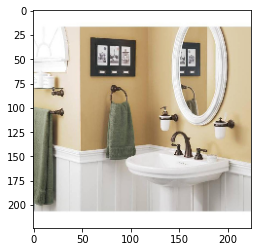

In [29]:
plt.imshow(data[0][0].reshape(224, 224, 3))

In [63]:
device = torch.device('cuda:0')

In [ ]:
import timm
weights = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=8)
weights = weights.to(device)
weights.save(weights.state_dict(), 'alexguo.pth')

In [37]:
params = {'input_channels':3, 'dim':768, 'hidden_dim':3072, 'patch_size':16, 'img_size':224, 'num_layers':12, 'ft_classes': None, 
          'dropout':0.1, 'attention_dropout':0.1, 'num_heads':12, 'num_classes':8, 'encoder_norm':True, 'fc_norm':False}

In [38]:
model = VisionTransformer(**params)
model = model.to(device)
model.load_state_dict(torch.load('alexguo.pth', map_location=device))

In [41]:
optimizer = optim.AdamW(model.parameters(), lr=0.001)
loss = nn.CrossEntropyLoss()

In [42]:
len(data)

25524

In [44]:
train, val = torch.utils.data.random_split(data, [22972, 2552])

In [45]:
# change whatever params u need i just have 16 batch size cuz my gpu memory is bad
trainloader = torch.utils.data.DataLoader(train, batch_size=16, num_workers=8, shuffle=True)
valloader = torch.utils.data.DataLoader(val, batch_size=16, num_workers=8, shuffle=True)

In [53]:
test_img = torch.tensor(data[0][0], device=device, dtype=torch.float32).unsqueeze(0)

In [54]:
kek = model(test_img)

In [59]:
torch.argmax(kek) # dumb ass vit lmfao

tensor(2, device='cuda:0')

In [ ]:
avg_tloss, avg_vloss = [], []

for e in range(100):
    t_loss, v_loss = [], []
    for x, y in trainloader:
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        y_pred = model(x.float())
        l = loss(y_pred, y)
        npl = l.detach().cpu().numpy()
        l.backward()
        optimizer.step()
        t_loss.append(npl)
        
    with torch.no_grad():    
        for x, y in valloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x.float())
            l = loss(y_pred, y)
            npl = l.detach().cpu().numpy()
            v_loss.append(npl)
    
    avg_tloss.append(np.mean(t_loss))
    avg_vloss.append(np.mean(v_loss))
    
    print(f'Epoch: {e}, Training Loss: {np.mean(t_loss)}, Validation Loss: {np.mean(v_loss)}')